In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# file was downloaded from Kaggle — Face Mask ~12K Images Dataset
# link: https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

!unzip /content/drive/'My Drive'/data/face_mask_dataset_12k_353MB.zip

In [ ]:
import os
import cv2
import random
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report,metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Input,Flatten,Dense,Dropout,Conv2D,MaxPooling2D,Activation

print(tf.__version__)
print(cv2.__version__)

2.4.0
4.1.2


In [ ]:
TRAIN_DIR = 'data/Train/'
VALID_DIR = 'data/Validation/'
TEST_DIR  = 'data/Test/'

IMG_SIZE = (150, 150)

INPUT_SHAPE = (150, 150, 3)
NUM_CLASSES = 2

NUM_EPOCHS = 50
BATCH_SIZE = 16

FACE_CLASSIFIER = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

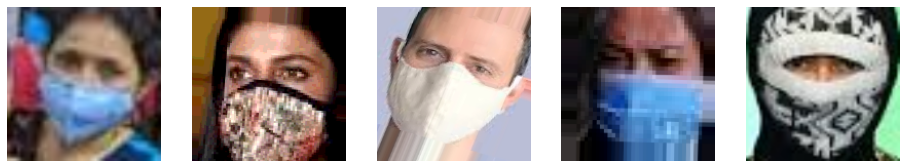

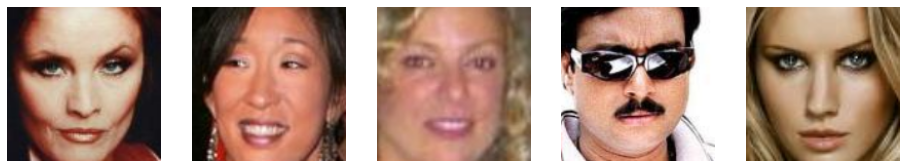

In [ ]:
def train_images(add_path):
    plt.figure(figsize=(16,6))
    for i in range(5):
        sample = random.choice(os.listdir(TRAIN_DIR+add_path+'/'))
        plt.subplot(1,5,i+1)
        img = cv2.imread(TRAIN_DIR+add_path+'/'+sample)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

train_images('WithMask')
train_images('WithoutMask')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

Found 10000 images belonging to 2 classes.


In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 800 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb', 
    shuffle=False,    
    class_mode='categorical')

Found 992 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Input(shape=INPUT_SHAPE))
model.add(Conv2D(16,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Conv2D(512,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES,activation='softmax',kernel_regularizer=l1(1e-4)))

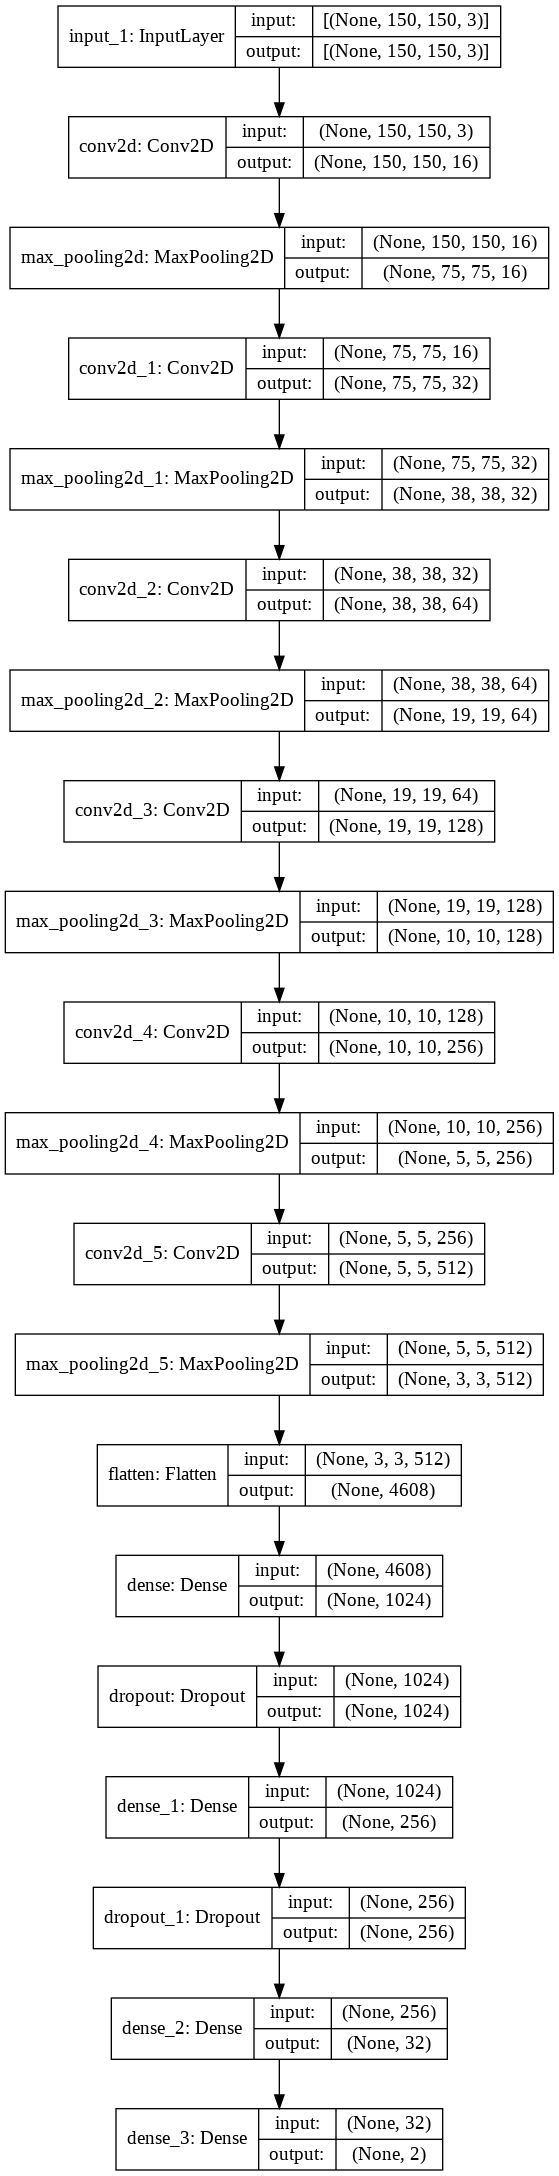

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 128)       7

In [ ]:
model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-7),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.save('data/model.h5')

In [ ]:
STEPS_TRAIN=train_generator.n//train_generator.batch_size
STEPS_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='loss',
                              patience=2,
                              min_delta=1e-7,
                              verbose=2,
                              factor=.2,
                              min_lr=1e-10,
                              mode='auto')

early_stopping = EarlyStopping(monitor='loss',
                               min_delta=1e-7,
                               patience=10,
                               verbose=2,
                               mode='auto',
                               restore_best_weights=False)

model_checkpoint = ModelCheckpoint('data/best_model.h5',
                                   monitor='val_accuracy',
                                   verbose=1, 
                                   save_best_only=True, 
                                   save_weights_only=True,
                                   mode='auto')

In [ ]:
hist = model.fit(train_generator,
                 steps_per_epoch=STEPS_TRAIN,
                 epochs=NUM_EPOCHS,
                 validation_data=valid_generator,
                 validation_steps=STEPS_VALID,
                 callbacks=[model_checkpoint, reduce_lr, early_stopping])

Epoch 1/50
625/625 [==============================] - 69s 99ms/step - loss: 0.4271 - accuracy: 0.8063 - val_loss: 0.3127 - val_accuracy: 0.8775

Epoch 00001: val_accuracy improved from -inf to 0.87750, saving model to data/best_model.h5
Epoch 2/50
625/625 [==============================] - 62s 99ms/step - loss: 0.2665 - accuracy: 0.8911 - val_loss: 0.1690 - val_accuracy: 0.9375

Epoch 00002: val_accuracy improved from 0.87750 to 0.93750, saving model to data/best_model.h5
Epoch 3/50
625/625 [==============================] - 62s 99ms/step - loss: 0.2161 - accuracy: 0.9159 - val_loss: 0.1451 - val_accuracy: 0.9475

Epoch 00003: val_accuracy improved from 0.93750 to 0.94750, saving model to data/best_model.h5
Epoch 4/50
625/625 [==============================] - 61s 98ms/step - loss: 0.1826 - accuracy: 0.9312 - val_loss: 0.1192 - val_accuracy: 0.9663

Epoch 00004: val_accuracy improved from 0.94750 to 0.96625, saving model to data/best_model.h5
Epoch 5/50
625/625 [=======================

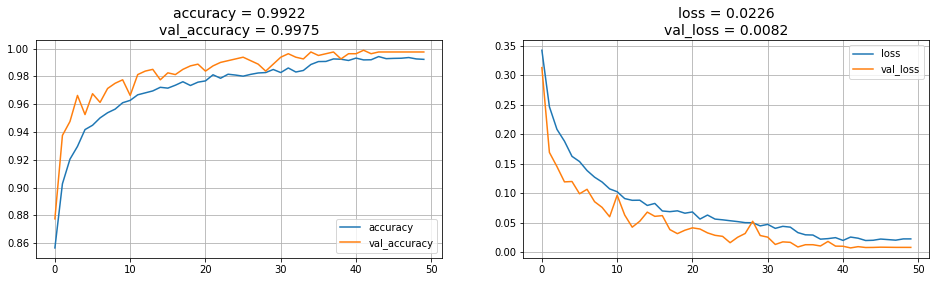

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title(('accuracy = {:.4f}\nval_accuracy = {:.4f}'.format(hist.history['accuracy'][-1],
                                                             hist.history['val_accuracy'][-1])), fontsize=14)
plt.grid(True)
plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title(('loss = {:.4f}\nval_loss = {:.4f}'.format(hist.history['loss'][-1],
                                                     hist.history['val_loss'][-1])), fontsize=14)
plt.grid(True)
plt.show();

In [ ]:
y_test = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
print(classification_report(y_test, y_pred, target_names=['Yes Mask','No Mask']))

              precision    recall  f1-score   support

    Yes Mask       0.99      1.00      1.00       483
     No Mask       1.00      0.99      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



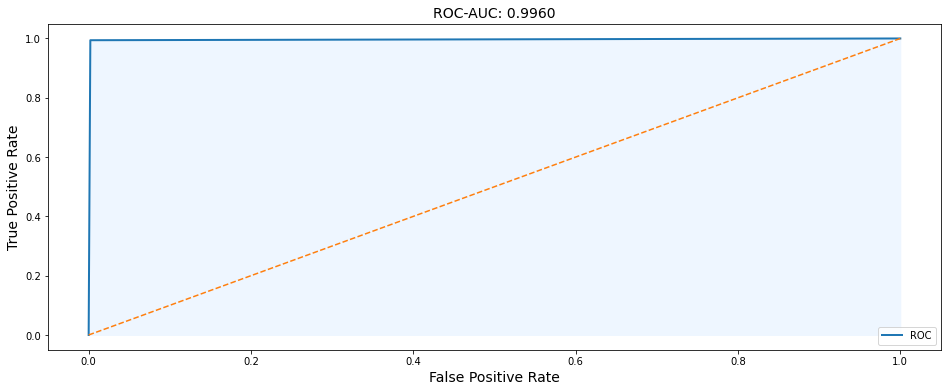

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(16,6))
plt.plot(fpr, tpr, label='ROC', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.fill_between(fpr, tpr, color='#eef6ff')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC-AUC: {:.4f}'.format(roc_auc), fontsize=14)
plt.legend()
plt.show();

In [ ]:
final_loss, final_accuracy = model.evaluate(test_generator)
print('Accuracy: {:.4f}\nLoss: {:.4f}'.format(final_accuracy, final_loss))

62/62 [==============================] - 1s 24ms/step - loss: 0.0204 - accuracy: 0.9960
Accuracy: 0.9960
Loss: 0.0204


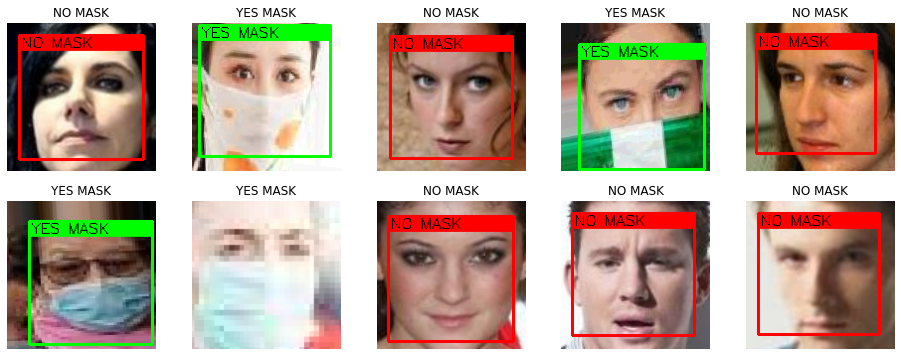

In [ ]:
plt.figure(figsize=(16,6))
for i in range(10):
    idx = random.randint(0,test_generator.n-1)
    plt.subplot(2,5,i+1)

    img = cv2.imread(TEST_DIR+test_generator.filenames[idx])
    img = cv2.resize(img,IMG_SIZE)
    faces = FACE_CLASSIFIER.detectMultiScale(img,scaleFactor=1.01,minNeighbors=3)
    
    for (x,y,w,h) in faces:
        if y_pred[idx]==1:
            title = 'NO MASK'
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
            cv2.rectangle(img,(x,y),(x+w,y+15),(0,0,255),-1)
            cv2.putText(img,'NO MASK',(x+2,y+12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
        else:
            title = 'YES MASK'
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.rectangle(img,(x,y),(x+w,y+15),(0,255,0),-1)
            cv2.putText(img,'YES MASK',(x+2,y+12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
        
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
plt.show()

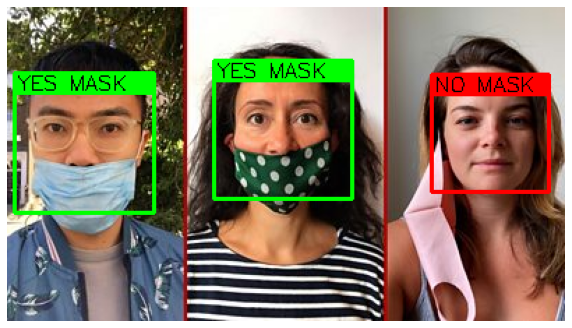

In [ ]:
img2 = cv2.imread('111.jpg')
faces2 = FACE_CLASSIFIER.detectMultiScale(img2, scaleFactor=1.33,minNeighbors=1)

if len(faces2)>=0:
    new_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
    for i in range(len(faces2)):
        (x,y,w,h) = faces2[i]
        crop_face = new_img2[y:y+h,x:x+w]
        crop_face = cv2.resize(crop_face,IMG_SIZE)
        crop_face = np.reshape(crop_face,[1,150,150,3])/255.0
        prediction = model.predict(crop_face)
        
        if prediction.argmax() == 1:
            cv2.rectangle(new_img2,(x,y),(x+w,y+h),(255,0,0),2)
            cv2.rectangle(new_img2,(x,y),(x+w,y+15),(255,0,0),-1)
            cv2.putText(new_img2,'NO MASK',(x+2,y+12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
        else:
            cv2.rectangle(new_img2,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.rectangle(new_img2,(x,y),(x+w,y+15),(0,255,0),-1)
            cv2.putText(new_img2,'YES MASK',(x+2,y+12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img2)
    plt.axis('off')
plt.show()

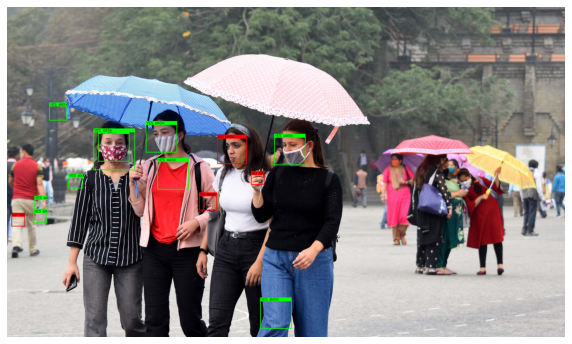

In [ ]:
img3 = cv2.imread('01.jpg')
faces3 = FACE_CLASSIFIER.detectMultiScale(img3, scaleFactor=1.33,minNeighbors=1)

if len(faces3)>=0:
    new_img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)
    for i in range(len(faces3)):
        (x,y,w,h) = faces3[i]
        crop_face = new_img3[y:y+h,x:x+w]
        crop_face = cv2.resize(crop_face,IMG_SIZE)
        crop_face = np.reshape(crop_face,[1,150,150,3])/255.0
        prediction = model.predict(crop_face)
        
        if prediction.argmax() == 1:
            cv2.rectangle(new_img3,(x,y),(x+w,y+h),(255,0,0),2)
            cv2.rectangle(new_img3,(x,y),(x+w,y+15),(255,0,0),-1)
            cv2.putText(new_img3,'NO MASK',(x+2,y+12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
        else:
            cv2.rectangle(new_img3,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.rectangle(new_img3,(x,y),(x+w,y+15),(0,255,0),-1)
            cv2.putText(new_img3,'YES MASK',(x+2,y+12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img3)
    plt.axis('off')
plt.show()

In [ ]:
# FACE MASK DETECTING FROM LOCAL CAMERA

# model = tf.keras.models.load_model('data/best_model.h5')

# cap = cv2.VideoCapture(1)
    
# while True:
#     _, img = cap.read()
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     faces = face_classifier.detectMultiScale(gray, 1.1, 4)
        
#     if len(faces)>=0:
#         new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
#         for i in range(len(faces)):
#             (x,y,w,h) = faces[i]
#             crop_face = new_img[y:y+h,x:x+w]
#             crop_face = cv2.resize(crop_face,(150,150))
#             crop_face = np.reshape(crop_face,[1,150,150,3])/255.0
#             prediction = model.predict(crop_face)
                
#             if prediction.argmax() == 1:
#                 cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),2)
#                 cv2.rectangle(new_img,(x,y),(x+w,y+15),(255,0,0),-1)
#                 cv2.putText(new_img,'NO MASK',(x+2,y+12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
#             else:
#                 cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
#                 cv2.rectangle(new_img,(x,y),(x+w,y+15),(0,255,0),-1)
#                 cv2.putText(new_img,'YES MASK',(x+2,y+12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)

#     cv2.imshow('Face mask detecting', cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
#     k = cv2.waitKey(30)
#     if k == 27:
#         break
# cv2.destroyAllWindows()
# cv2.waitKey(0)